Начнем выполнение задания с импортирования необходимой библиотеки для работы с таблицами.

Подсчитаем количество строк в файле "train.csv", чтобы получить представление о размере данных.

После подсчета оказалось, что размер исходного файла слишком большой для полной загрузки в память.Загрузим первые 25 миллионов строк из файла "train.csv".

Загружам дополнительные данные из файлов "questions.csv" и "lectures.csv", которые будут использоваться для объединения с основной таблицей.

In [1]:
import pandas as pd

# Подсчет строк и частичная загрузка train.csv
with open("train.csv", "r") as file:
    row_count = sum(1 for row in file)
    print(f"Количество строк в файле: {row_count}")

# Загружаем первые 25 миллионов строк
train = pd.read_csv('train.csv', nrows=25000000)
questions = pd.read_csv('questions.csv')
lectures = pd.read_csv('lectures.csv')

# Просмотр первых строк и информации о данных
print("Train DataFrame (первые 5 строк):")
print(train.head())
print(train.info())

print("\nQuestions DataFrame (первые 5 строк):")
print(questions.head())
print(questions.info())

print("\nLectures DataFrame (первые 5 строк):")
print(lectures.head())
print(lectures.info())


Количество строк в файле: 101230333
Train DataFrame (первые 5 строк):
   row_id  timestamp  user_id  content_id  content_type_id  task_container_id  \
0       0          0      115        5692                0                  1   
1       1      56943      115        5716                0                  2   
2       2     118363      115         128                0                  0   
3       3     131167      115        7860                0                  3   
4       4     137965      115        7922                0                  4   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                          NaN   
1            2                   1                      37000.0   
2            0                   1                      55000.0   
3            0                   1                      19000.0   
4            1                   1                      11000.0   

  prior_question_had_explanation  
0    

Объединим таблицу `train` с таблицей `questions` по столбцам "content_id" (из train) и "question_id" (из questions).
Выберем только нужные столбцы из `questions`: "question_id", "tags" и "part".

Объединим `train_questions` с таблицей `lectures` по столбцам "content_id" (из train_questions) и "lecture_id" (из lectures).
Выберем столбцы "lecture_id", "tag" и "type_of" из `lectures`.

Также проверим на пропуски в объединённых данных с помощью метода `isnull().sum()`.

In [2]:
# Объединение данных train с questions и lectures
train_questions = train.merge(questions[['question_id', 'tags', 'part']], left_on="content_id", right_on="question_id", how="inner")
train_full = train_questions.merge(lectures[['lecture_id', 'tag', 'type_of']], left_on="content_id", right_on="lecture_id", how="inner")

# Проверим пропуски после объединения
print("\nTrain DataFrame после объединения (первые 5 строк):")
print(train_full.head())
print("\nПроверка на пропуски в данных:")
print(train_full.isnull().sum())


Train DataFrame после объединения (первые 5 строк):
   row_id  timestamp  user_id  content_id  content_type_id  task_container_id  \
0      18     437272      115        7926                0                 18   
1      23     557677      115         185                0                 23   
2      30     710402      115         100                0                 30   
3      89     653762     2746        6808                1                 14   
4      95     835457     2746         484                0                 19   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            1                   1                      18000.0   
1            3                   0                      21000.0   
2            0                   1                      20000.0   
3           -1                  -1                          NaN   
4            0                   1                      20000.0   

  prior_question_had_explanation  question_id            

Начнем анализ данных, за основу возьмем следующие наиболее интересные показатели:

1) Процент правильно отвеченных вопросов.

2) Корреляция между временем, затраченным на вопрос ('prior_question_elapsed_time'), и правильностью ответа ('answered_correctly').

3) Влияние объяснений на правильность ответа 

4) Теги вопросов. Для этого для каждого уникального тега в столбце 'tags' рассчитаем средний процент правильных ответов.

5) Средняя правильность ответов по категориям лекций.


In [4]:
# Процент правильно отвеченных вопросов
correct_percentage = train_full['answered_correctly'].mean()
print(f"\nПроцент правильно отвеченных вопросов: {correct_percentage * 100:.2f}%")

# Влияние времени на правильность ответа
time_vs_correctness = train_full[['prior_question_elapsed_time', 'answered_correctly']].dropna()
print("\nКорреляция между временем и правильностью ответа:")
print(time_vs_correctness.corr())

# Влияние объяснений на правильность ответа
explanation_effect = train_full.groupby('prior_question_had_explanation')['answered_correctly'].mean()
print("\nСредняя правильность по наличию объяснений:")
print(explanation_effect)

# Теги вопросов
tags_analysis = train_full.groupby('tags')['answered_correctly'].mean()
print("\nСредняя правильность по тегам вопросов:")
print(tags_analysis)

# Категории лекций
part_analysis = train_full.groupby('part')['answered_correctly'].mean()
print("\nСредняя правильность по категориям лекций (part):")
print(part_analysis)



Процент правильно отвеченных вопросов: 5.19%

Корреляция между временем и правильностью ответа:
                             prior_question_elapsed_time  answered_correctly
prior_question_elapsed_time                     1.000000           -0.033427
answered_correctly                             -0.033427            1.000000

Средняя правильность по наличию объяснений:
prior_question_had_explanation
False   -0.848784
True     0.677624
Name: answered_correctly, dtype: float64

Средняя правильность по тегам вопросов:
tags
1                      -0.322354
10 178 38              -0.799595
106 12 102             -0.362459
106 38 29              -0.922431
106 67 92               0.202477
                          ...   
96                     -0.502804
98 118 21              -0.968923
98 84 118 35 122 162    0.352941
98 84 18 35 122        -0.123846
98 84 97 135 162        0.324324
Name: answered_correctly, Length: 99, dtype: float64

Средняя правильность по категориям лекций (part):
part
1

Для наглядоности построим графики при помощи библиотеки matplotlib:

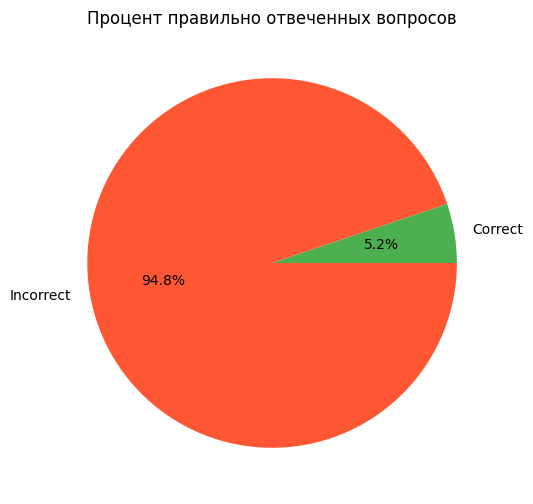

In [5]:
import matplotlib.pyplot as plt

# Процент правильно отвеченных вопросов
correct_percentage = train_full['answered_correctly'].mean()

plt.figure(figsize=(6, 6))
plt.pie([correct_percentage, 1 - correct_percentage], labels=["Correct", "Incorrect"], autopct='%1.1f%%', colors=["#4CAF50", "#FF5733"])
plt.title('Процент правильно отвеченных вопросов')
plt.show()


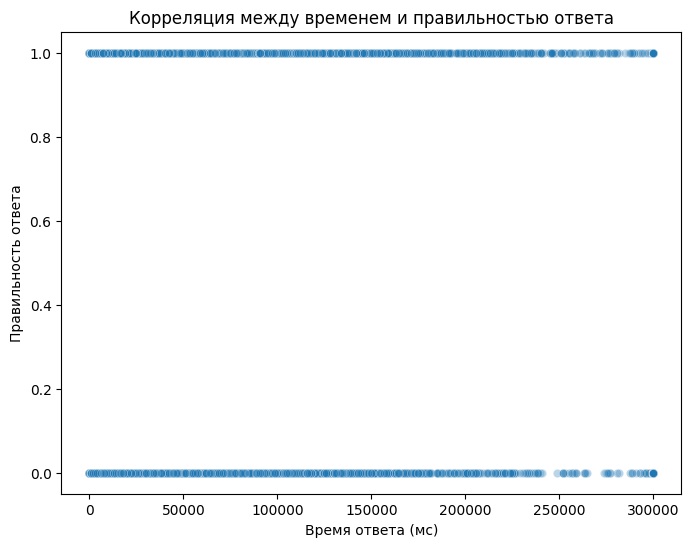

In [6]:
import seaborn as sns

# Корреляция между временем и правильностью ответа
time_vs_correctness = train_full[['prior_question_elapsed_time', 'answered_correctly']].dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=time_vs_correctness, x='prior_question_elapsed_time', y='answered_correctly', alpha=0.3)
plt.title('Корреляция между временем и правильностью ответа')
plt.xlabel('Время ответа (мс)')
plt.ylabel('Правильность ответа')
plt.show()


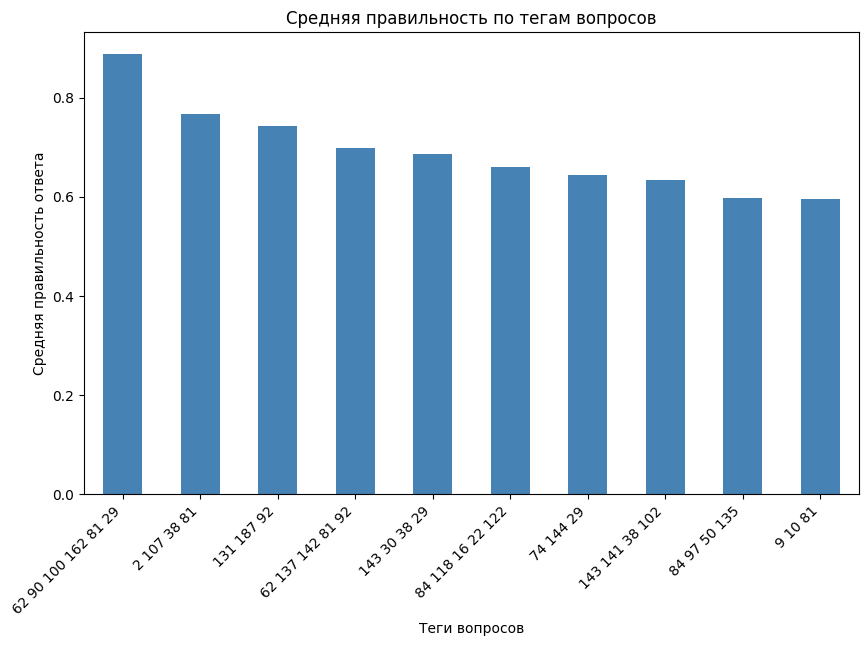

In [8]:
# Средняя правильность по тегам вопросов
tags_analysis = train_full.groupby('tags')['answered_correctly'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
tags_analysis.plot(kind='bar', color='steelblue')
plt.title('Средняя правильность по тегам вопросов')
plt.xlabel('Теги вопросов')
plt.ylabel('Средняя правильность ответа')
plt.xticks(rotation=45, ha='right')
plt.show()


/tmp/ipykernel_22645/2228567312.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=part_analysis.index, y=part_analysis.values, palette='Set2')


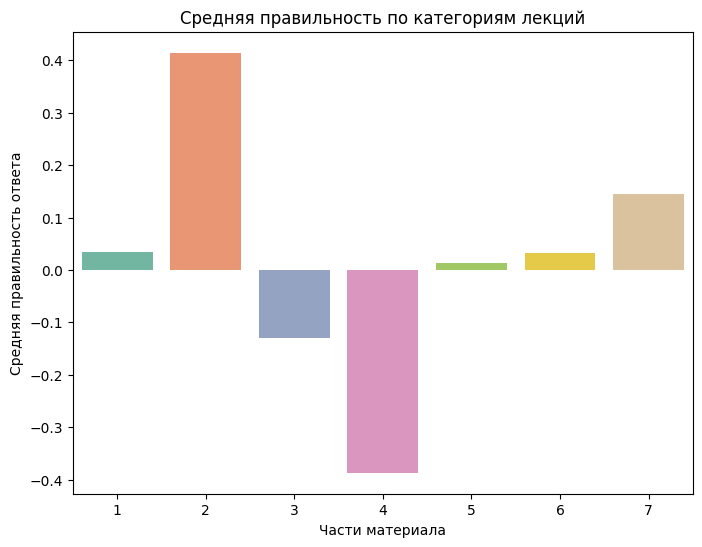

In [9]:
# Средняя правильность по категориям лекций
part_analysis = train_full.groupby('part')['answered_correctly'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=part_analysis.index, y=part_analysis.values, palette='Set2')
plt.title('Средняя правильность по категориям лекций')
plt.xlabel('Части материала')
plt.ylabel('Средняя правильность ответа')
plt.show()


## Общие выводы

1. **Процент правильных ответов**:
   - Процент правильно отвеченных вопросов составляет **5.19%**.
   - Это может указывать на высокую сложность вопросов или трудности в правильном ответе. 

2. **Корреляция между временем и правильностью ответа**:
   - **Корреляция** между временем и правильностью ответа составляет **-0.033**, что близко к нулю.
   - Это может означать, что **время не имеет существенного влияния** на правильность ответа. Возможно, время не является ключевым фактором в успешности выполнения задач (например, если человек не знает ответа на вопрос, ему врятли помогут дополнительное время для того, чтобы вспомнить или предположить).

3. **Средняя правильность по наличию объяснений**:
   - Для вопросов с **объяснением** правильность ответа составляет **0.6776**, а для вопросов без объяснения **-0.8488**.
   - **Наличие объяснений значительно улучшает результат**. Учащиеся отвечают правильно гораздо чаще, когда знают, о чем они говорят и могут объяснить свой ответ.

4. **Средняя правильность по тегам вопросов**:
   - Некоторые теги, такие как **"106 38 29"** и **"10 178 38"**, имеют очень низкие значения правильности (от **-0.8 до -0.9**), что указывает на **высокую сложность вопросов** в этих категориях.
   - Другие теги, такие как **"106 67 92"**, показывают положительные результаты, что говорит о **легкости вопросов** с такими тегами.
   - Анализ тегов может помочь понять, над какими темами нужно больше работать.

5. **Средняя правильность по категориям лекций (part)**:
   - Категории лекций с более высокими результатами правильных ответов: **part 2, part 7**, а также **part 1** и **part 5**.
   - Категории с более низкими результатами: **part 3** и **part 4** .
   - Это может говорить о том, что стоит переработать некоторые категории для повышения успеваемости. 